# Signal Classification Models

<br><br>
**#TODO:** Re-run LSTM, 1D_CNN and 1D_CNN_LSTM (validation set added)  <br>
**#TODO:** re-run manual_feature_extraction.py, I have changed the classifiers. <br>
**#TODO:** re-run train_and_evaluation.py, I have changed the classifiers. <br>
**#TODO:** Refractor the MultiHeadDataGenerator class so that it can be used on any number of heads instead of only 3.  <br>
**#TODO:** README <br>
**#TODO:** Upload all the extracted data to a server and add a link/command to download it; remove the data from the git repository. <br>
**#TODO:** Upload 1_Demostration.ipynb to a kaggle kernel.<br>

<br>

On this project I realize a review of several different models and techniques used for signal classification. The models are implemented in Python and some in MATLAB. 
The methods and models that I have built for the comparison are listed below.
The complete code for the implementation of all the model can be found on their respective files, which are indicated on the description of each section.
<br/>
### Models:
 * **Feature extraction + Classifier**

 * **Automated feature extraction + Classifier**

 * **CNN_1D** (1 dimensional convolutional network)

 * **LSTM** (Long short-term memory neural network)

 * **CNN_1D + LSTM**

 * **CWT + CNN_2D(MobileNet)** (Continuous wavelet transform + 2D convolutional network)
 
 * **Wavelet Time Scattering + Classifier**

<br/>

I will be using the data set "Human Activity Recognition Using Smartphones" from the UCI database. 
The experiment consists of a set of people performing six activities (WALKING, WALKING UPSTAIRS, WALKING DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. 
The embedded accelerometer and gyroscope of the phone is then used to record the 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The objective is to predict which activity is performing the person.

Each sample individual sample we have 9 signals with a total length of 128 readings:

body_acc_x_train, body_acc_y_train, body_acc_z_train, body_gyro_x_train, body_gyro_y_train, body_gyro_z_train, total_acc_x_train, total_acc_y_train, total_acc_z_train

Activities description:
1. walking
2. walking upstairs
3. walking downstairs
4. sitting
5. standing
6. laying
 
The data set can be found on the following link:
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

<br>

**Reference resources**

Here some materials and resources from which I have learned some of the methods shown on this notebook and that I would recommend to people starting learning about signal processing and classification.

* **#TODO:** Add more stuff here 

* "*Signal processing problems, solved in MATLAB and in Python", by Mike X Cohen (Udemy Course).* <a href="https://www.udemy.com/course/signal-processing/"> Link</a>. 

* *Signal Processing Toolbox documentation (tutorials and examples).* <a href="https://www.mathworks.com/help/signal/signal-generation-and-preprocessing.html?category=signal-generation-and-preprocessing&s_tid=CRUX_gn_documentation_signal-generation-and-preprocessing"> Link</a>.

* "*Deep Learning for Time Series Forecasting", by Jason Brownlee* (Book).

* *Ahmet Taspinar blog (Deep learning blog).* <a href="http://ataspinar.com/"> Link</a>.
* 


<br> 


*I haven't done yet a thoroughly parameter tuning to any of the models, so I am pretty sure that the accuracy of most of them could be easily improve with a bit of parameter tuning.*



#### Free cloud GPU servers
*(If needed of more computer power)*

- Google colab (TPU / GPU  Nvidia T4s, K80s, P4s and P100s)
- Kaggle kernel (GPU Nvidia Telsa P100)

In [0]:
# Just run this and it should be ready to go.
!git clone https://github.com/JoaquinRives/Signal_Classification_Models

!pip install -r Signal_Classification_Models/requirements.txt

import os
os.chdir("Signal_Classification_Models")

Cloning into 'Signal_Classification_Models'...
remote: Enumerating objects: 14517, done.
remote: Counting objects: 100% (14517/14517), done.
remote: Compressing objects: 100% (7334/7334), done.
remote: Total 20781 (delta 7197), reused 14494 (delta 7182), pack-reused 6264
Receiving objects: 100% (20781/20781), 2.71 GiB | 21.21 MiB/s, done.
Resolving deltas: 100% (10294/10294), done.
Checking out files: 100% (20663/20663), done.
     |████████████████████████████████| 81kB 1.4MB/s 


In [0]:
nvidia-smi

<br>

## Signals

<br>

In [1]:
from data_handling import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [10, 5]

In [0]:
# Load data
X_train, X_test, y_train, y_test = load_dataset()

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 2947 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})


#### Plot the distribution of each signal

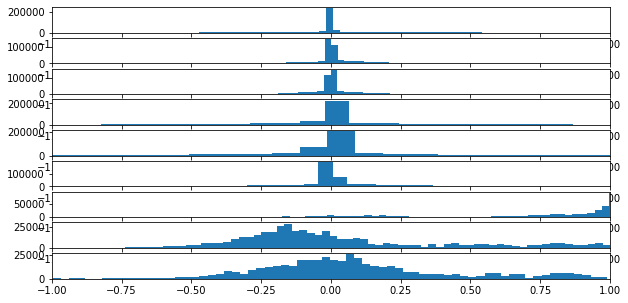

In [0]:
def plot_variable_distributions(trainX):
    """ Plots a histogram of each variable in the data set """
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    plt.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        plt.hist(longX[:, i], bins=100)
    plt.show()

    
# Plot a histogram of each signal
plot_variable_distributions(X_train)

#### Plot the distribution of the labels

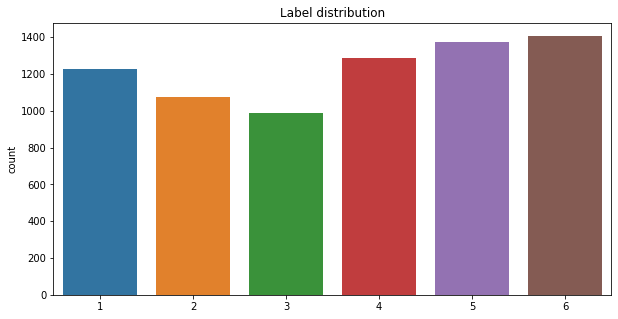

In [0]:
# Count plot of the target labels
sns.countplot(y_train, )
plt.title("Label distribution")
plt.show()


<br/>

## Feature extraction + Classifier
<br/>

Code implementation:
> **manual_feature_extraction.py**


One of the most commonly used methods for signal classification consist on, instead of passing directly the signal to the model, extract features from the signal and pass those signals to a classifier model. The signals that I have extracted are:

* **FFT :**  The coordinates in axis x and y of the n first significant peaks of the signal in the frequency domain after applying the Fast Fourier Transform.
* **PSD :**  First n significant peaks from the Power Spectral Density analysis of the signal.
* **Autocorrelation :**  First n significant peaks of the auto-correlation coefficients.
* **Entropy (Shannon)**
* **Zero crossing rate**
* **Mean crossing rate**
* **Statistic features :**  (n5, n25, n75, n95, median, mean, std, var, rms)

Many more features can be extracted, the ones shown here are just a representation of the most commonly used. Domain-knowledge of the signals we want to classify is important in order to know which features we should extract for a better classification.

All the features are passed as vector to the classifier. @TODO different classifiers are evaluated. The results are shown below.

In [0]:
import manual_feature_extraction

# Run experiment:each experiments is repeated n times and the average
# and standard deviation of the results is calculated
manual_feature_extraction.run_experiment(repeats=10)

----------------------------------------
Average score: 93.790% (+/-0.000)
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=30, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=300,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False) 

----------------------------------------
Average score: 91.110% (+/-0.000)
Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svc',
                 SVC(C=1.0, break_ties=F

<br/>

## Automated Feature Extraction + Classifier

Code implementation:
> **automated_feature_extraction / extract_features.py**<br/>
> **automated_feature_extraction / select_features.py**<br/>
> **automated_feature_extraction / train_and_evaluate.py**<br/>

Another way of extracting features is using a package like tfresh (https://tsfresh.readthedocs.io/), which can be used to extract automatically a very large number of features (over 700 hundred features). Besides extracting the features, it can also be used for feature selection.
The drawback is the computational time that it takes to extract all the features. It over 2 hours on my laptop (i7, 16Gb RAM).
> pip install tfresh

As the signals have 9 components, I have done the extraction and selection independently for each component and then concatenated all the features together before fitting the model.

The total number of features extracted from each signal was is 6786, from which 1793 were selected.


In [8]:
from auto_feature_extraction import extract_features, select_features, train_and_evaluate

In [0]:
extract_features.extract()

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [13:26<00:00, 40.34s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_0: 754


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [12:43<00:00, 38.18s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_1: 754


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [13:14<00:00, 39.72s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_2: 754


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [13:01<00:00, 39.07s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_3: 754


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [14:24<00:00, 43.21s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_4: 754


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [12:43<00:00, 38.16s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_5: 754


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [12:55<00:00, 38.79s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_6: 754


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [13:46<00:00, 41.35s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_7: 754


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [12:45<00:00, 38.29s/it]
 '0__fft_coefficient__coeff_65__attr_"angle"'
 '0__fft_coefficient__coeff_65__attr_"imag"'
 '0__fft_coefficient__coeff_65__attr_"real"'
 '0__fft_coefficient__coeff_66__attr_"abs"'
 '0__fft_coefficient__coeff_66__attr_"angle"'
 '0__fft_coefficient__coeff_66__attr_"imag"'
 '0__fft_coefficient__coeff_66__attr_"real"'
 '0__fft_coefficient__coeff_67__attr_"abs"'
 '0__fft_coefficient__coeff_67__attr_"angle"'
 '0__fft_coefficient__coeff_67__attr_"imag"'
 '0__fft_coefficient__coeff_67__attr_"real"'
 '0__fft_coefficient__coeff_68__attr_"abs"'
 '0__fft_coefficient__coeff_68__attr_"angle"'
 '0__fft_coefficient__coeff_68__attr_"imag"'
 '0__fft_coefficient__coeff_68__attr_"real"'
 '0__fft_coefficient__coeff_69__attr_"abs"'
 '0__fft_coefficient__coeff_69__attr_"angle"'
 '0__fft_coefficient__coeff_69__attr_"imag"'
 '0__fft_coefficient__coeff_69__attr_"real"'
 '0__fft_coefficient__co

Features extracted from sig_comp_8: 754


In [0]:
select_features.select()

loading signal_comp_0.csv


selecting features...
selected 203 features.
loading signal_comp_1.csv


selecting features...
selected 166 features.
loading signal_comp_2.csv


selecting features...
selected 184 features.
loading signal_comp_3.csv


selecting features...
selected 154 features.
loading signal_comp_4.csv


selecting features...
selected 178 features.
loading signal_comp_5.csv


selecting features...
selected 177 features.
loading signal_comp_6.csv


selecting features...
selected 261 features.
loading signal_comp_7.csv


selecting features...
selected 234 features.
loading signal_comp_8.csv


selecting features...
selected 236 features.
saving automatic_feature_extraction/data_selected/train.csv
saving automatic_feature_extraction/data_selected/test.csv


In [9]:
train_and_evaluate.train_evaluate()

Accuracy: 87.34% 

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=300,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


Accuracy: 87.45% 

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=30, class_weight=None, dual=False,
                                    fit_intercept=True, interce

The accuracies are a bit lower than in the previous example where the features where specifically selected and extracted. Definitely it isn't worth the amount of time that it took to extract them. Maybe with other data sets the result would be different, but what is clear is that knowing the signal you are working with, and which of its features are relevant, is very important.

<br/>

## 1D_Convolutional_Network
<br/>

Code implementation:

> **1D_CNN.py**

<br/>
The next model is a 1-dimensional multi-headed convolutional network, where each head of the model reads the input time steps using a different sized kernel (3, 5, 11) allowing the model to read and interpret the sequence data at three different resolutions. The interpretations from all three heads are then concatenated within the model and interpreted by a fully connected layer before a prediction is made.

<br/>
<br/>


***
<img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/img_models/multihead_1D_CNN.png?raw=1" width=840/>

***

<br/>

In [0]:
import CNN_1D

CNN_1D.run_experiment(repeats=10, verbose=0)

>#1: 92.671
>#2: 91.788
>#3: 92.060
>#4: 93.146
>#5: 93.247
>#6: 92.297
>#7: 92.195
>#8: 93.112
>#9: 93.281
>#10: 92.942
[92.67051238547675, 91.7882592487141, 92.05972175093315, 93.14557176789955, 93.24737020901271, 92.29725144214456, 92.19545300305396, 93.11163895486936, 93.28130302002036, 92.94197488971835]
Score: 92.674% (+/-0.521)


**92.674% (+/-0.521)** accuracy. As we can see, the 1D_CNN does a good job at identifying the activity from the signals.

<br>

## LSTM



<br>

Code implementation:
> **LSTM.py**



Recurrent neural networks are also very popular on time-series data. Recurrent neural network (RNN) have "memory", being able of remember input from the past. Long short-term memory (LSTM) networks are one of the most useful types of RNN architecture thanks to their characteristic use of "gates" to reduce the error that would be back-propagated through time and layers otherwise.

<br>

***

<img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/img_models/LSTM.png?raw=1" width=280/>

***

<br>

In [0]:
import LSTM

LSTM.run_experiment(repeats=5, verbose=0)

> Rep_1: 97.246
> Rep_2: 96.799
> Rep_3: 96.991
> Rep_4: 96.986
> Rep_5: 96.850
[97.24578844477534, 96.7990067517268, 96.99129260593566, 96.98563689978438, 96.84990590655039]
Score: 96.974% (+/-0.155)


The results are pretty good, **96.974% (+/-0.155)** accuracy. Even better than the the maximum accuracy achieved by feature extraction, and with the advantage that it isn't needed to expend time extracting features or have any knowledge about the signal.

<br><br>

## CNN_1D + LSTM

<br>

Code implemetation:

> **CNN_1D_LSTM.py**



This conbination can be very powerful. On this model the CNN layers of the model read subsequences of the main sequence as in blocks, extracting features and temporal patterns from each block, then allowing the LSTM to interpret the features extracted from each block. It is very useful when the sequences are to large for the LSTM to remember, as the CNN layers will "compress" the sequence.

This combination can also give very great results when the features in the signal that we want to detect are spreaded on time, and the exact position of those features isn't relevant.

<br>

***

<img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/img_models/CNN_1D_LSTM.png?raw=1" width=310/>

***

<br>

**#TODO:** Re-run, I have modified the model <br>
**#TODO:** Add more reps and params so te plot looks better

> Rep_1: 97.308
> Rep_2: 97.495
> Rep_3: 97.427
> Rep_4: 96.912
> Rep_5: 97.082
> Rep_1: 97.500
> Rep_2: 97.031
> Rep_3: 97.602
> Rep_4: 97.410
> Rep_5: 97.020
> Rep_1: 97.382
> Rep_2: 97.342
> Rep_3: 97.285
> Rep_4: 97.376
> Rep_5: 97.070
> Rep_1: 97.184
> Rep_2: 97.557
> Rep_3: 97.065
> Rep_4: 97.150
> Rep_5: 97.150
[[97.30799871054107, 97.49462918220718, 97.42676342670336, 96.91211604287271, 97.0817799138586], [97.50028475891504, 97.03088095320011, 97.60208300384053, 97.40979708490997, 97.01956964809287], [97.38152010747444, 97.3419316954883, 97.2853767920398, 97.37586440132317, 97.0704693429382], [97.1835783529492, 97.55683961988993, 97.06481370150861, 97.1496456693624, 97.14964534575388]] [3, 5, 7, 11]
Score: 97.267% (+/-0.197)
Kernel=[3, 5, 7, 11]: 97.245% (+/-0.218)
Kernel=[3, 5, 7, 11]: 97.313% (+/-0.242)
Kernel=[3, 5, 7, 11]: 97.291% (+/-0.115)
Kernel=[3, 5, 7, 11]: 97.221% (+/-0.172)


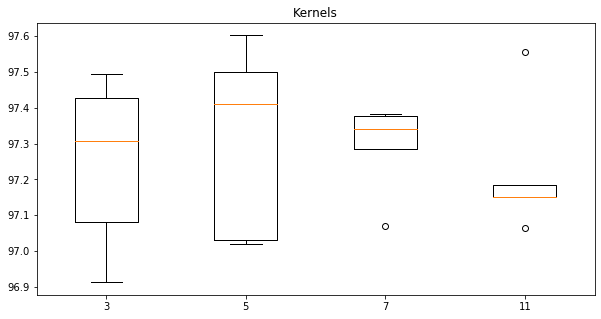

In [0]:
import CNN_1D_LSTM

# Test also using different CNN kernels
kernels = [(3, 3), (5, 7) , (11, 13)]

# Run experiment
CNN_1D_LSTM.run_experiment(repeats=7, kernel=kernels, verbose=0)

Even better, #TODO acucuracy. This conbination of 1D_CNN and LSTM give the best results so far. All the kernels give similar accuracy...#TODO


<br>

## CWT_2D_CNN


Convolution network (2D) on time/frequency representations (scalograms) extracted using the Continuous Wavelet Transform Filter Blank.

***

> **CWT_scalograms.m** <br>
> **data_generator_classes.py** <br>
> **CWT_CNN_MobileNet.py** <br>
> **CWT_CNN_VGG16.py** <br>
> **CWT_3xCNN_#TODO.py** <br>

***

#### Continuous Wavelet Transform Filter Bank

On this model the Continuous Wavelet Transform (CWT) is applied to each of the signal and the resulting 2-dimensional coefficient matrix (1 for each signal component) are used as input "images" to the model. The resulting input as the following shape: 224,224,9 (height, width, channels), one "channel" for each of the signal components (total_acc_x, total_acc_y, total_acc_z,body_acc_x, body_acc_y, body_acc_z, body_gyr_x, body_gyr_y, body_gyr_z).

Time/frequency analysis of the signals using the wavelet transform allows us to extract information from the signal in both, frequency and time domains. The wavelet transform filter banks it is also better than other methods as the transformation at different scales achieves the best resolution trade-off between time and frequency (high resolution in the frequency domain for small frequency values | high resolution in the time domain for for large frequency values).

I have used MATLAB and the Signal Processing Toolbox to obtain the scalograms.
The full code to obtain the scalograms is on the MATLAB file "**CWT_scalograms.m**".

<br>

<table>
    <tr>
        <td> <img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/data_scalograms/scalogram_example_1.png?raw=1" alt="Drawing" width=450/> </td>
        <td> <img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/data_scalograms/scalogram_example_2.png?raw=1" alt="Drawing" width=450/> </td>
    </tr>
    <tr>
        <td> <img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/data_scalograms/scalogram_example_3.png?raw=1" width=450/> </td>
        <td> <img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/data_scalograms/scalogram_example_4.png?raw=1" width=450/> </td>
    </tr>
</table>

<br>

#### Keras Data Generators

To feed the scalograms images to the model we also need to create a custom data_generator. Data_generators are used to load input data from the drive on small batches as needed when training the model. That way we avoid running out of RAM memory when working with large data sets. The generators are defined on the "**data_generator_classes.py**" file. 

More info about keras data generators:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

<br>

#### MobileNet

#### Input shape 

For this model I wanted to try using transfer learning from one of the state-of-the-art pre-train models available on keras. To do that we can reuse the convolutional part of the model and remove the top. The pre-trained weights are also kept. Then we add our own dense layers on top so that they can learn to classify our specific data set. (In keras the "top" layers means the last layers of the model).

However, there is a problem. All the pre-train models (or most of them) have been trained on the "imagenet" dataset, which are RGB images (3 channels), if we want to use transfer learning and keep the pre-trained weights of the model, the maximum number of channels that we can pass as input to the model is 3. But we have 9 channels (signal components) that we need to feed to the model. 

<br>

To overcome this problem I have tried 3 possible solutions:


**1)**  Not using the pre-trained weigths of the model (no tranfer learning) and use only its architecture. In this case we need to re-train all the layers of the model.


**2)**  Concatenate the  scalograms of the 3 axis (x, y, z) of each signal together (kind of a rough solution @@@but it seems to work). That way we reduce from 9 channels to just three. This is how a single channel would look like:

<img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/data_scalograms/triple_scalogram_example.png?raw=1" width=350/>

<br>

**3)**  Concatenate 3 models on parallel to build a three-headed model, where each head takes a different input (3 signals/channels each head). The outputs of the 3 convolutional heads are then merged together and feeded as input to our dense layers:

<br>

***


<br>

**1. CWT_CNN_MobileNet (no transfer learning)**

<br>

> CWT_CNN_MobileNet.py

<br>

MobileNet is a very deep and yet very fast model, as it was originaly designed to be used on mobile and embedded vision applications where the computational power is limited. On this model the weights aren't pre-loaded and all layers are set to be re-trained.

<br>

<img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/img_models/CWT_CNN_MobileNet_horizontal.png?raw=1" />

<br>

In [0]:
import CWT_CNN_MobileNet

CWT_CNN_MobileNet.run_experiment(repeats=2, verbose=1) #TODO Verbose=0

Using TensorFlow backend.













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
229/229 [==============================] - 152s 663ms/step - loss: 1.2363 - acc: 0.4045 - val_loss: 4.8605 - val_acc: 0.2031
Epoch 2/2
92/92 [==============================] - 25s 272ms/step
>Repeat_1: 33.560
Epoch 1/2
229/229 [==============================] - 136s 596ms/step - loss: 1.2811 - acc: 0.3772 - val_loss: 7.5801 - val_acc: 0.1997
Epoch 2/2
92/92 [==============================] - 25s 270ms/step
>Repeat_2: 17.425
[33.559782608695656, 17.425271739130434]
Score: 25.493% (+/-8.067)


The results aren't very good, I tried other models (VGG16, ResNet, InceptionV3...), and only MobileNet achieved higher than 70% accuracy. Besides the models shown on this notebook I also tried with more simple models that I build myself and the results weren't great either.

<br>

**2. CWT_CNN_VGG16 (concatenating 3 scalograms on 1 channel)**

<br>

> CWT_CNN_VGG16.py

<br>

<img src="https://github.com/JoaquinRives/aaaaa/blob/master/data/img_models/CWT_CNN_VGG16_horizontal.png?raw=1" />

<br>

In [0]:
import CWT_CNN_VGG16

CWT_CNN_VGG16.run_experiment(repeats=2)


58892288/58889256 [==============================] - 2s 0us/step
Epoch 1/2
229/229 [==============================] - 94s 410ms/step - loss: 1.1292 - acc: 0.4625 - val_loss: 1.0273 - val_acc: 0.4745
Epoch 2/2
92/92 [==============================] - 26s 287ms/step
> Rep_1: 54.450
Epoch 1/2
229/229 [==============================] - 88s 385ms/step - loss: 1.1671 - acc: 0.4615 - val_loss: 1.1655 - val_acc: 0.4888
Epoch 2/2
92/92 [==============================] - 25s 273ms/step
> Rep_2: 52.514
[54.44972826086957, 52.51358695652174]
Score: 53.482% (+/-0.968)


<br>

#### **3. CWT_3xCNN_VGG16**

<br>

> CWT_3xCNN_VGG16.py

<br>

The results of this model are the worst ones...#TODO 

In [0]:
import CWT_3xCNN_VGG16

CWT_3xCNN_VGG16.run_experiment(repeats=2)

<br><br>
**#TODO:** Implement the CWT also in python <br>
**#TODO:** Try to use other types of wavelets to see if it improves. <br>
**#TODO:** Use a different data set. 
<br><br>

<br>

## Wavelet Time Scattering + Classifier

<br>

> **wavelet_scattering.m**

<br>


#### Wavelet time scattering

Wavelet time scattering consist on using wavelets transforms to extract low-variance features from signal, time series or image data. Wavelet time scattering yields signal representations insensitive to shifts in the input signal without sacrificing class discriminability.

To extract the scattering features, I have used MATLAB and the Signal Processing Toolbox. The full code is on the MATLAB file "**wavelet_scattering.m**".

On of the advantages of using wavelet time scattering is its relative high speed and computational efficiency. On my laptop it took less than **4** seconds to extract all of the 1944 features of each signal that are going to be used for the classification.

From each signal component, with the wavelet decomposition framework that was used in MATLAB, we obtain 27 features on 8 different time windows *(see on the wavelet_scattering.m script)*. 

**27** features **&#215; 8** Nwin **&#215; 9** sign_comp  **=**  **1944** total features 

When can join all the features together or classify each time window independently and then apply majority vote to get the final results. I have put an example using majority vote on the wavelet_scattering.m script. Here for simplicity I am just going to add all the time window features together on a single vector. The accuracy of both methods is almost the same.

<br>



In [6]:
from scipy.io import loadmat
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.neural_network import MLPClassifier


def evaluate_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy(y_test, y_pred)
    score = acc * 100.0
    return score


def run_experiment(repeats=2):
    # Load data
    data_dir = 'data/wavelet_scattering/'
    train_features = 'train_WTS_features.mat'
    test_file = 'test_WTS_features.mat'

    X_train = loadmat(data_dir + 'train_WTS_features.mat')['all_features_train']
    X_test = loadmat(data_dir + 'test_WTS_features.mat')['all_features_test']
    y_train = loadmat(data_dir + 'train_WTS_labels.mat')['sequence_labels_train'][1, :]
    y_test = loadmat(data_dir + 'test_WTS_labels.mat')['sequence_labels_test'][1, :]

    time_windows = 8

    # Concatenate all the time window features together
    train_shape = (X_train.shape[0] // time_windows, X_train.shape[1] * time_windows)
    test_shape = (X_test.shape[0] // time_windows, X_test.shape[1] * time_windows)

    X_train = np.reshape(X_train, train_shape)
    X_test = np.reshape(X_test, test_shape)

    # Shuffle data
    index = [i for i in range(len(X_train))]
    np.random.shuffle(index)
    X_train = X_train[index]
    y_train = y_train[index]

    # Models
    classifiers = [
        make_pipeline(MinMaxScaler(), LogisticRegression()),
        make_pipeline(StandardScaler(), LogisticRegression(C=30)),
        make_pipeline(StandardScaler(), SVC(kernel='rbf')),
        make_pipeline(MinMaxScaler(), KNeighborsClassifier()),
        RandomForestClassifier(n_estimators=1000, n_jobs=-1),
        make_pipeline(MinMaxScaler(), MLPClassifier(hidden_layer_sizes=(150, 100)))
    ]

    all_scores = list()
    for clf in classifiers:
        score = evaluate_model(clf, X_train, y_train, X_test, y_test)
        print("-"*60)
        print(f"{clf}\n")
        print(f"Score: {score}")


run_experiment()

------------------------------------------------------------
Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Score: 89.82015609093995
------------------------------------------------------------
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticReg

## Conclusion

Every data set is different, but on this specific data set LSTM and 1D_CNN_LSTM are the models that best performed, achieving an accuracy significally higher than the rest of the models.

Althoug both models have similar accuracy, 1D_CNN is faster than LSTM. The LSTM and 2D_CNN models I had to run all of them on the cloud, while the 1D_CNN models I was able to run them on my laptop on a reasonable amount of time.

On the other hand, the classification using the time/frequency representation (scalograms) did not achieved good results. I was expecting better results, I have used that convination before (Continuous wavelet transform + CNN model) and it has always worked very well.

... #TODO